In [1]:
from dotenv import load_dotenv
from tqdm import tqdm
import os, re

from hsg.featureanalysis.regelementcorr import read_bed_file, get_sequences_from_dataframe
from hsg.stattools.features import get_latent_model

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from biocommons.seqrepo import SeqRepo
import torch
import numpy as np

# Features to visualize
multiedge_core_pos_feats = [6296, 6445, 407, 2558, 4793, 835, 5234, 3378, 7612, 7799, 7949, 1867]
steered_feat = [7030, 8161, 1422]

load_dotenv()  # take environment variables from .env file

Importing Goodies...


/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/ek224/anaconda3/envs/hsg/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings

True

In [2]:
cisplat_binding_sites = read_bed_file("data/Nair_cisplatin_oct_25/RNAs/cisplatin_binding_sites.bed", max_columns=6)
print(cisplat_binding_sites)

100%|██████████| 11795/11795 [00:00<00:00, 1094025.11it/s]

       chrom  chromStart   chromEnd               name   score strand
0      chr12    65824760   65824860  ENSG00000149948-4  1000.0      +
1      chr12    65824560   65824660  ENSG00000149948-2  1000.0      +
2       chr4   104491549  104491649  ENSG00000245384-1  1000.0      +
3       chr4   104491908  104492008  ENSG00000168772-9  1000.0      -
4       chr5   126777323  126777423  ENSG00000113368-2  1000.0      +
...      ...         ...        ...                ...     ...    ...
11790   chr1    15765007   15765107  ENSG00000162458-1  1000.0      +
11791  chr15    48178132   48178232  ENSG00000104177-5  1000.0      -
11792  chr10    93702383   93702483  ENSG00000148690-1  1000.0      -
11793   chr1   173733741  173733841  ENSG00000076321-2  1000.0      +
11794  chr17    39402193   39402293  ENSG00000266469-1  1000.0      +

[11795 rows x 6 columns]


In [3]:
cisplat_seqs = get_sequences_from_dataframe(
    seqrepo=SeqRepo(os.getenv("SEQREPO_PATH")),
    df=cisplat_binding_sites,
    pad_size=0,
)
cisplat_binding_sites["sequences"] = cisplat_seqs

Fetching sequences: 100%|██████████| 11795/11795 [00:04<00:00, 2943.94it/s]


In [4]:
# Initialize NTv2 model + SAE
exp_factor = 8
layer_idx = 23
sae_path = f"/home/ek224/Hidden-State-Genomics/checkpoints/hidden-state-genomics/ef{exp_factor}/sae/layer_{layer_idx}.pt"
ntsae23 = get_latent_model(os.environ["NT_MODEL"], layer_idx, sae_path=sae_path)
# Freeze the model weights
for param in ntsae23.parameters():
    param.requires_grad = False

In [5]:
def extract_feature_activations_with_tokens(model, sequence, feature_id):
    """
    Extract SAE feature activations for a specific feature from a single sequence with token information.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequence: DNA sequence string to analyze
        feature_id: Feature index to extract
        
    Returns:
        tuple: (feature_activations, tokens)
            - feature_activations: numpy array of activations for the specified feature [num_tokens]
            - tokens: list of token strings for the sequence
    """
    model.eval()
    with torch.no_grad():
        sae_acts, tokens = model(sequence, return_tokens=True)
        # Strip special tokens if present (e.g., "<CLS>")
        tokens = [t for t in tokens if not re.match(r'^<.*>$', t)]
        
        # Extract activations for this specific feature across all tokens
        # sae_acts shape: [num_tokens, num_features]
        feat_acts = sae_acts[:, feature_id].cpu().numpy()
    
    return feat_acts, tokens


In [6]:
def site_directed_mutagenesis(sequence, position) -> list[str]:

    bases = ["A", "T", "C", "G"]

    if type(sequence) == str:
        sequence = sequence.upper()
    else:
        raise ValueError("Input sequence must be a string")
    
    mutated_sequences = []
    for mut_base in bases:
        if mut_base != sequence[position]:
            mutated_seq = sequence[:position] + mut_base + sequence[position+1:]
            mutated_sequences.append(mutated_seq)

    return mutated_sequences

In [7]:
def convert_basis(feature_activations, tokens) -> np.ndarray:
    """
    Convert token-level feature activations to base-level activations by averaging
    activations from overlapping k-mer tokens that cover each base.
    
    Args:
        feature_activations: numpy.ndarray of shape [num_tokens] - single feature activations
        tokens: List of token strings corresponding to the feature activations
        
    Returns:
        numpy.ndarray: Base-level feature activations corresponding to each base in the sequence
    """
    base_activations = []
    for t in tokens:
        base_activations.extend([feature_activations[tokens.index(t)]] * len(t))
    
    array = np.array(base_activations)
    return array


def snp_mutation_effect(model, sequence, feature_id, position) -> np.ndarray:
    """
    Calculate the effect of mutating a single base position to all 3 alternative bases
    on feature activation at all base positions.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequence: reference DNA sequence string
        feature_id: The feature index to analyze
        position: Base position to mutate
        
    Returns:
        numpy.ndarray: 1D array [affected_base_position] with averaged feature activation changes
                       across 3 mutations at the specified position
    """
    # Get baseline activations
    baseline_feat, baseline_tokens = extract_feature_activations_with_tokens(model, sequence, feature_id)
    baseline_base_acts = convert_basis(baseline_feat, baseline_tokens)
    
    # Get mutated sequences
    mut_seqs = site_directed_mutagenesis(sequence, position)
    
    # Calculate effects for each mutation
    effects = []
    for mut_seq in mut_seqs:
        mut_feat, mut_tokens = extract_feature_activations_with_tokens(model, mut_seq, feature_id)
        mut_base_acts = convert_basis(mut_feat, mut_tokens)
        
        # Calculate absolute difference
        effect = np.abs(mut_base_acts - baseline_base_acts)
        effects.append(effect)
    
    # Average across the 3 mutations
    mean_effect = np.mean(effects, axis=0)
    return mean_effect

def calculate_position_dependency_map(model, sequence, feature_id):
    """
    Calculate position-wise feature activity dependency for a sequence at base resolution.
    
    For each base position, mutate it to all 3 alternative bases and measure 
    the effect on feature activation at all base positions. Handles tokenization
    by attributing token activations to each base within the token.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequence: DNA sequence string
        feature_id: The feature index to analyze
        
    Returns:
        numpy.ndarray: 2D array [mutated_base_position, affected_base_position] with averaged
                       feature activation changes across 3 mutations per position
    """
    sequence = sequence.upper()
    seq_len = len(sequence)
    dependency_matrix = np.zeros((seq_len, seq_len))

    print(f"Computing dependency map for {seq_len} positions...")
    for pos in tqdm(range(seq_len), desc="Mutating positions"):
        dependency_matrix[pos, :] = snp_mutation_effect(model, sequence, feature_id, pos)
    
    return dependency_matrix


def plot_dependency_heatmap(dependency_matrix, sequence, feature_id, 
                           title=None, figsize=(14, 10), cmap='viridis'):
    """
    Plot position-wise feature activity dependency heat map at base resolution.
    
    Args:
        dependency_matrix: 2D numpy array [mutated_base_position, affected_base_position]
        sequence: Original DNA sequence string
        feature_id: Feature ID for labeling
        title: Custom title for the plot
        figsize: Figure size tuple
        cmap: Colormap name
        
    Returns:
        tuple: (fig, ax) matplotlib objects
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    sequence = sequence.upper()
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(dependency_matrix, aspect='auto', cmap=cmap, 
                   interpolation='nearest', origin='lower')
    
    # Set labels - Y axis has numeric positions, X axis has reference bases
    ax.set_xlabel('Affected Position (index:reference base)', fontsize=12)
    ax.set_ylabel('Mutated Position (index:reference base)', fontsize=12)
    
    if title is None:
        title = f'Position-wise Feature {feature_id} Activity Dependency\n(Average of Possible mutations per base position)'
    ax.set_title(title, fontsize=14, pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('|Δ Feature Activation|', rotation=270, labelpad=20, fontsize=11)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Set tick labels - show all positions
    seq_len = len(sequence)
    tick_positions = list(range(seq_len))
    
    # X-axis: show reference bases at affected positions
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f"{i}: ({sequence[i]})" for i in tick_positions], fontsize=6, 
                       rotation=90, ha='center')
    
    # Y-axis: show numeric positions that are mutated
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{i}: ({sequence[i]})" for i in tick_positions], fontsize=6)
    
    plt.tight_layout()
    return fig, ax


def analyze_sequence_dependency(model, sequence, feature_id, plot=True, save_path=None, title=None):
    """
    Complete workflow: calculate and optionally plot position-wise dependency at base resolution.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequence: DNA sequence string
        feature_id: The feature index to analyze
        plot: Whether to create visualization
        save_path: Optional path to save the plot
        title: Optional title for the plot
    Returns:
        dict: Contains dependency_matrix, and optionally fig/ax if plot=True
    """
    print(f"Calculating base-level position dependency map for feature {feature_id}...")
    print(f"Sequence length: {len(sequence)} bp")
    
    # Calculate dependency matrix at base resolution
    dep_matrix = calculate_position_dependency_map(model, sequence, feature_id)
    
    results = {'dependency_matrix': dep_matrix, 'sequence': sequence}
    
    if plot:
        print("Generating heat map...")
        fig, ax = plot_dependency_heatmap(dep_matrix, sequence, feature_id, title=title)
        results['fig'] = fig
        results['ax'] = ax
        
        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
    
    print(f"Max dependency delta: {dep_matrix.max():.4f}")
    print(f"Mean dependency delta: {dep_matrix.mean():.4f}")
    
    return results



Processing Feature 6296
Calculating base-level position dependency map for feature 6296...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_6296_dependency_map.png
Max dependency delta: 2.0103
Mean dependency delta: 0.3802


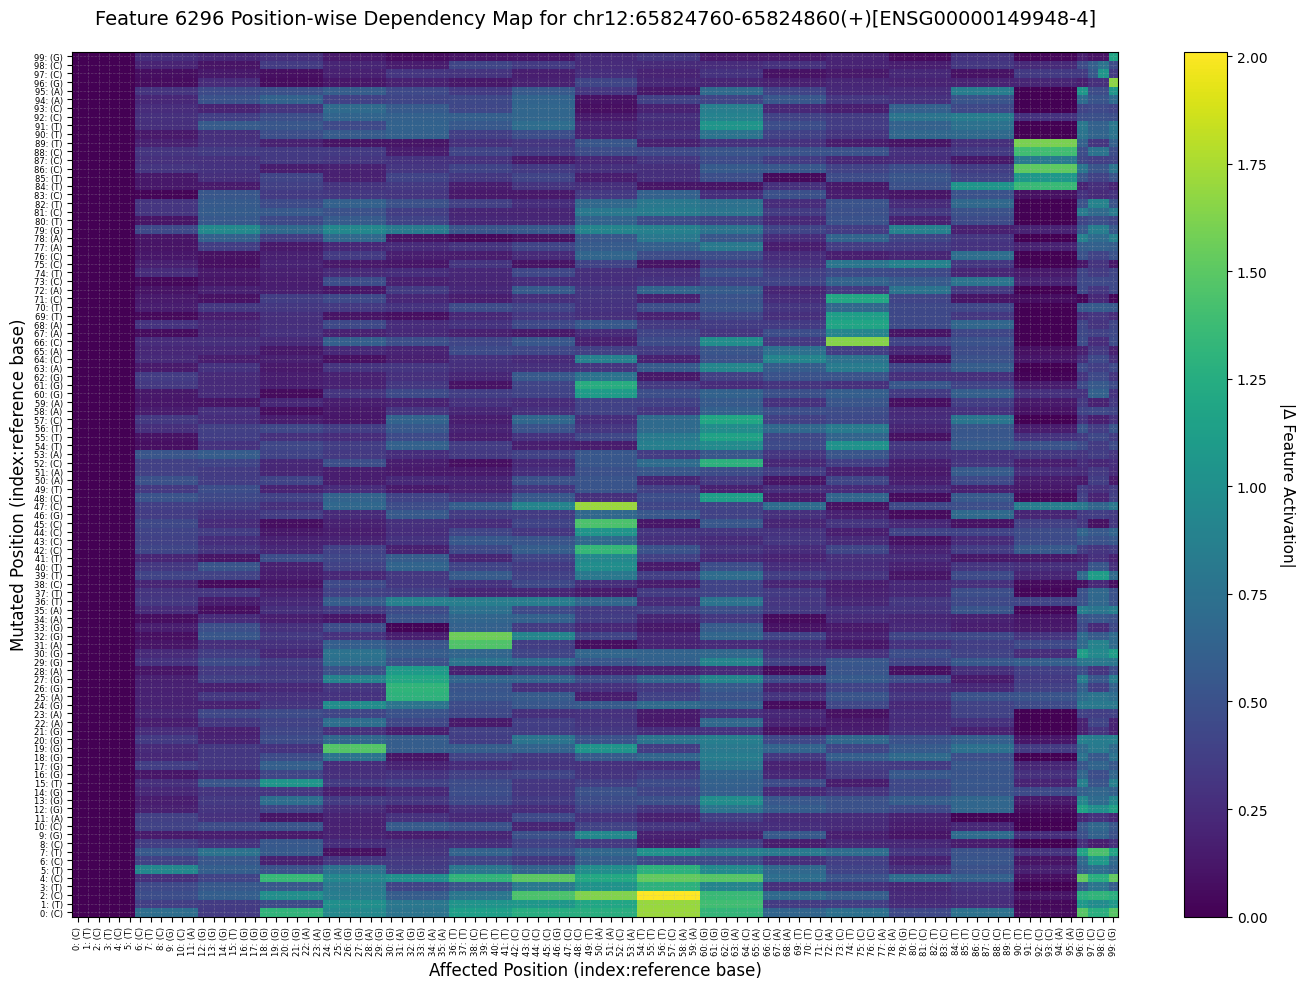


Processing Feature 6445
Calculating base-level position dependency map for feature 6445...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_6445_dependency_map.png
Max dependency delta: 3.3172
Mean dependency delta: 0.2350


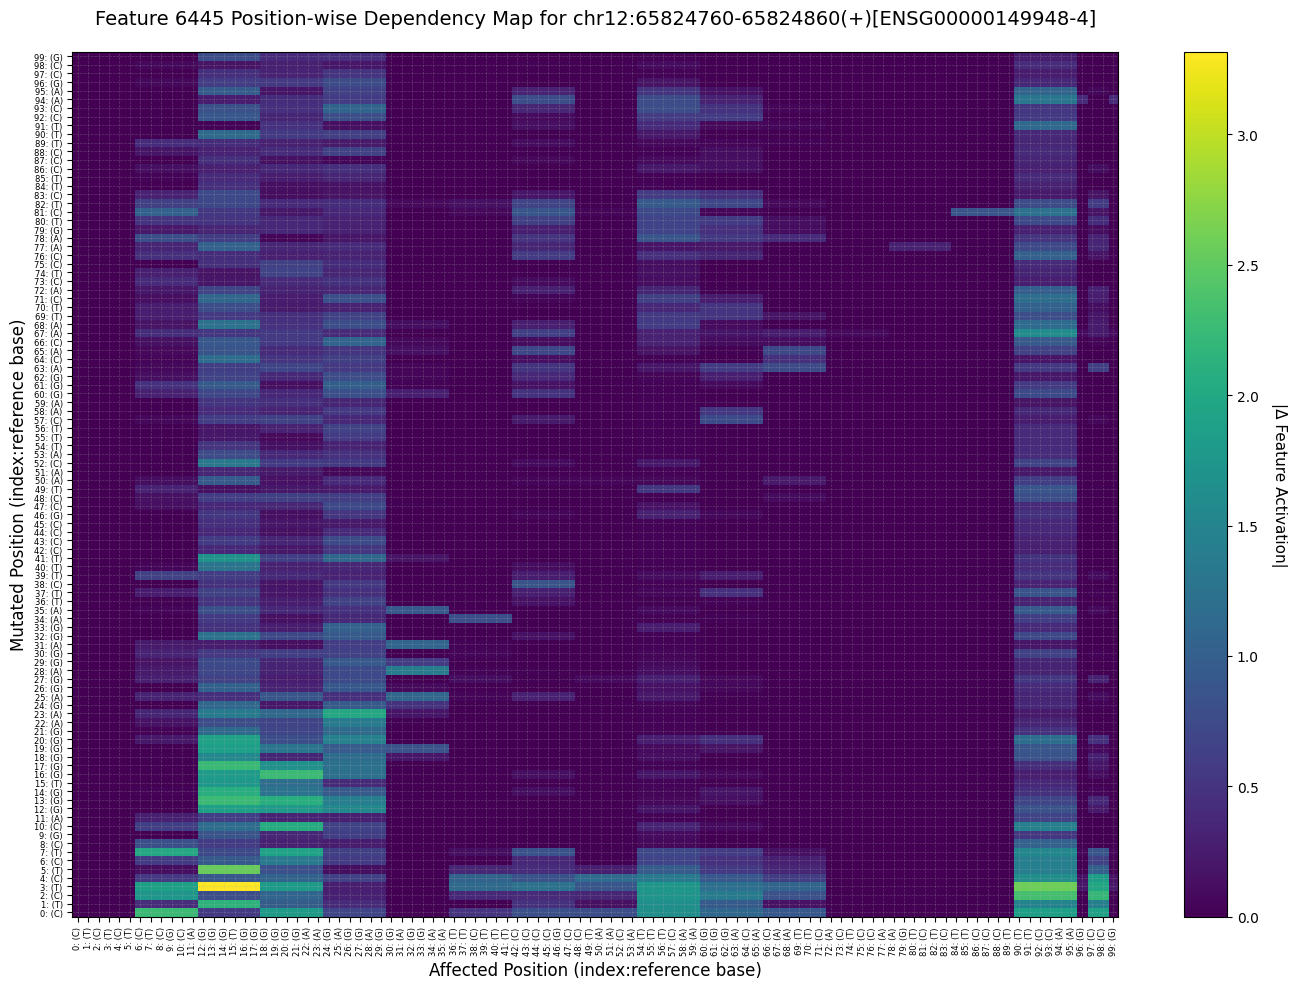


Processing Feature 407
Calculating base-level position dependency map for feature 407...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_407_dependency_map.png
Max dependency delta: 3.1665
Mean dependency delta: 0.6452


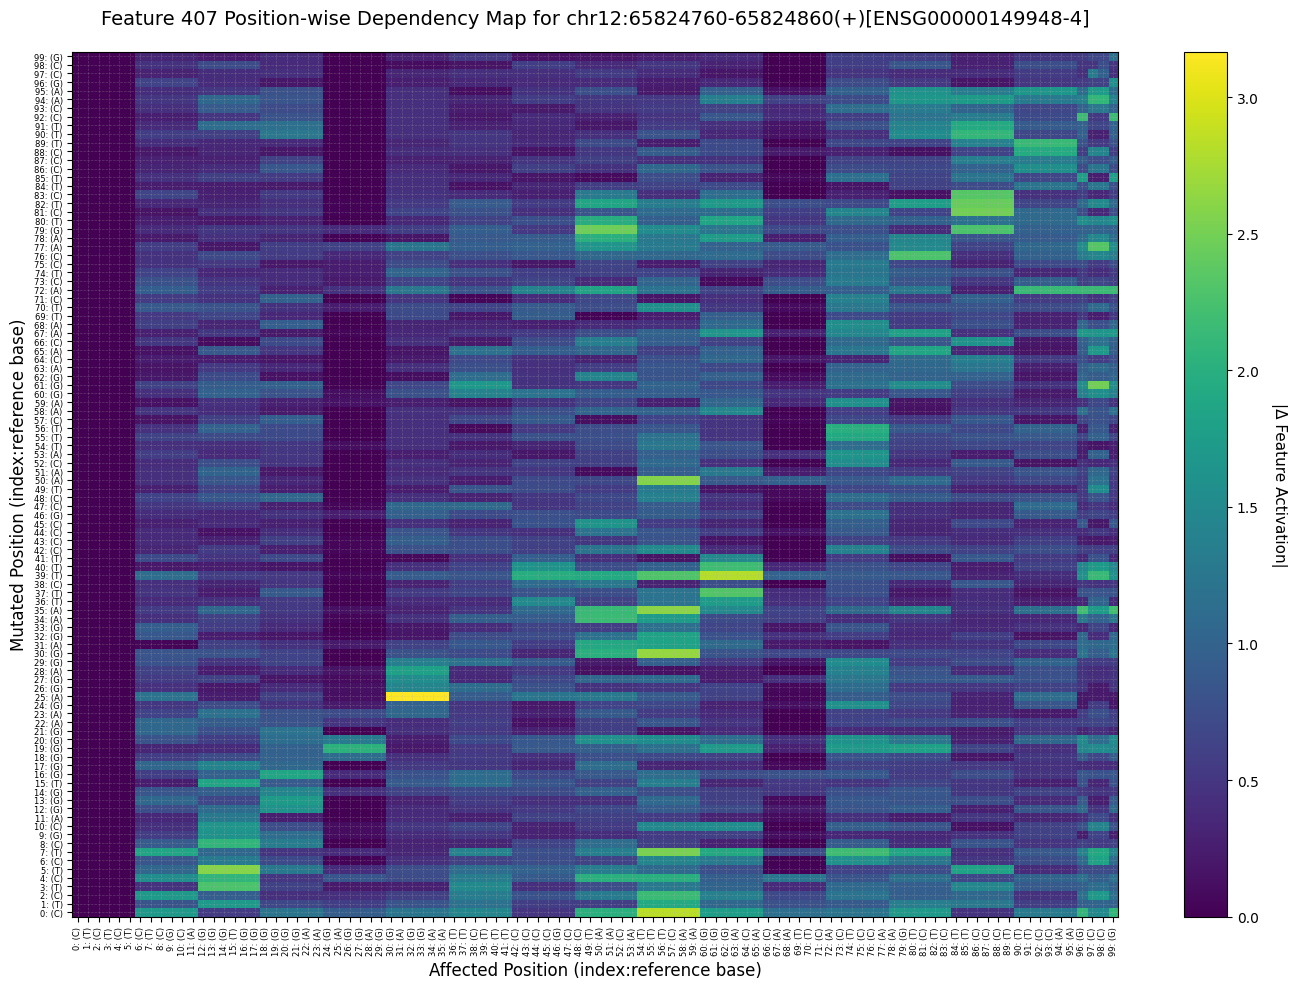


Processing Feature 2558
Calculating base-level position dependency map for feature 2558...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_2558_dependency_map.png
Max dependency delta: 2.5978
Mean dependency delta: 0.3615


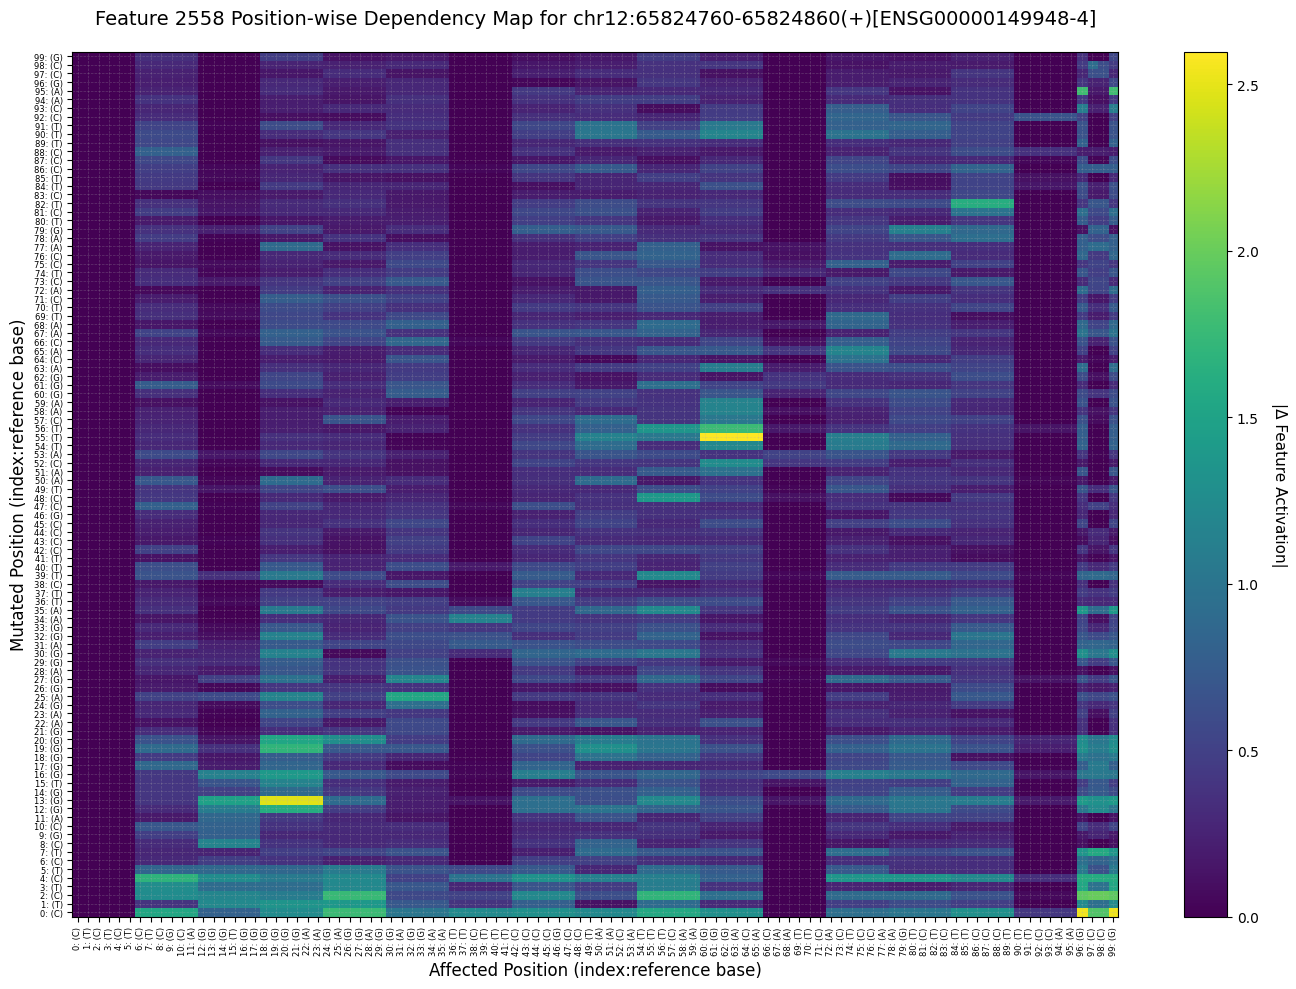


Processing Feature 4793
Calculating base-level position dependency map for feature 4793...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_4793_dependency_map.png
Max dependency delta: 3.1796
Mean dependency delta: 0.3746


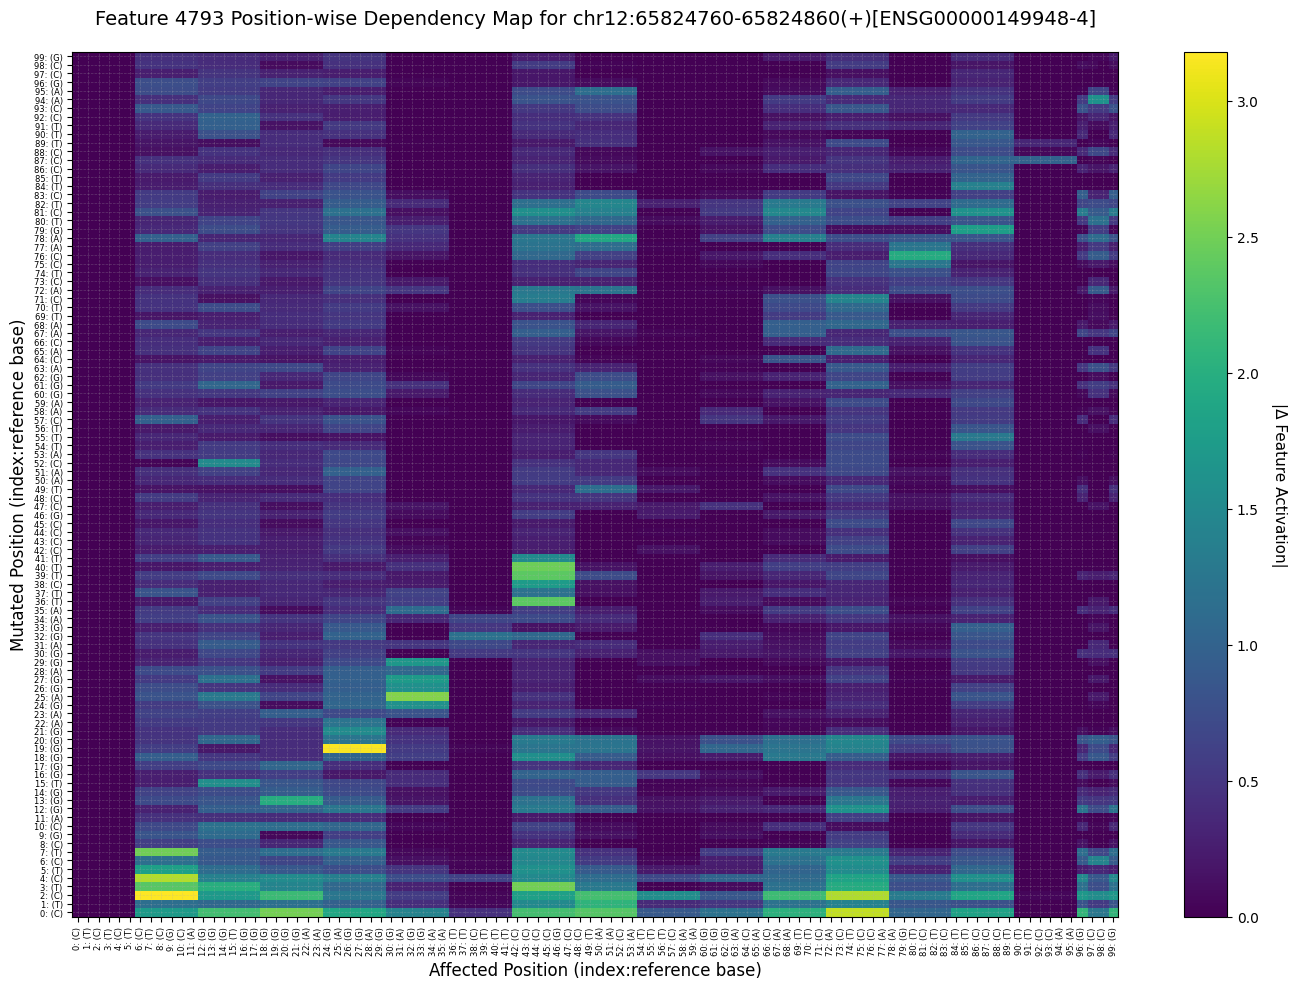


Processing Feature 835
Calculating base-level position dependency map for feature 835...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_835_dependency_map.png
Max dependency delta: 1.8583
Mean dependency delta: 0.3161


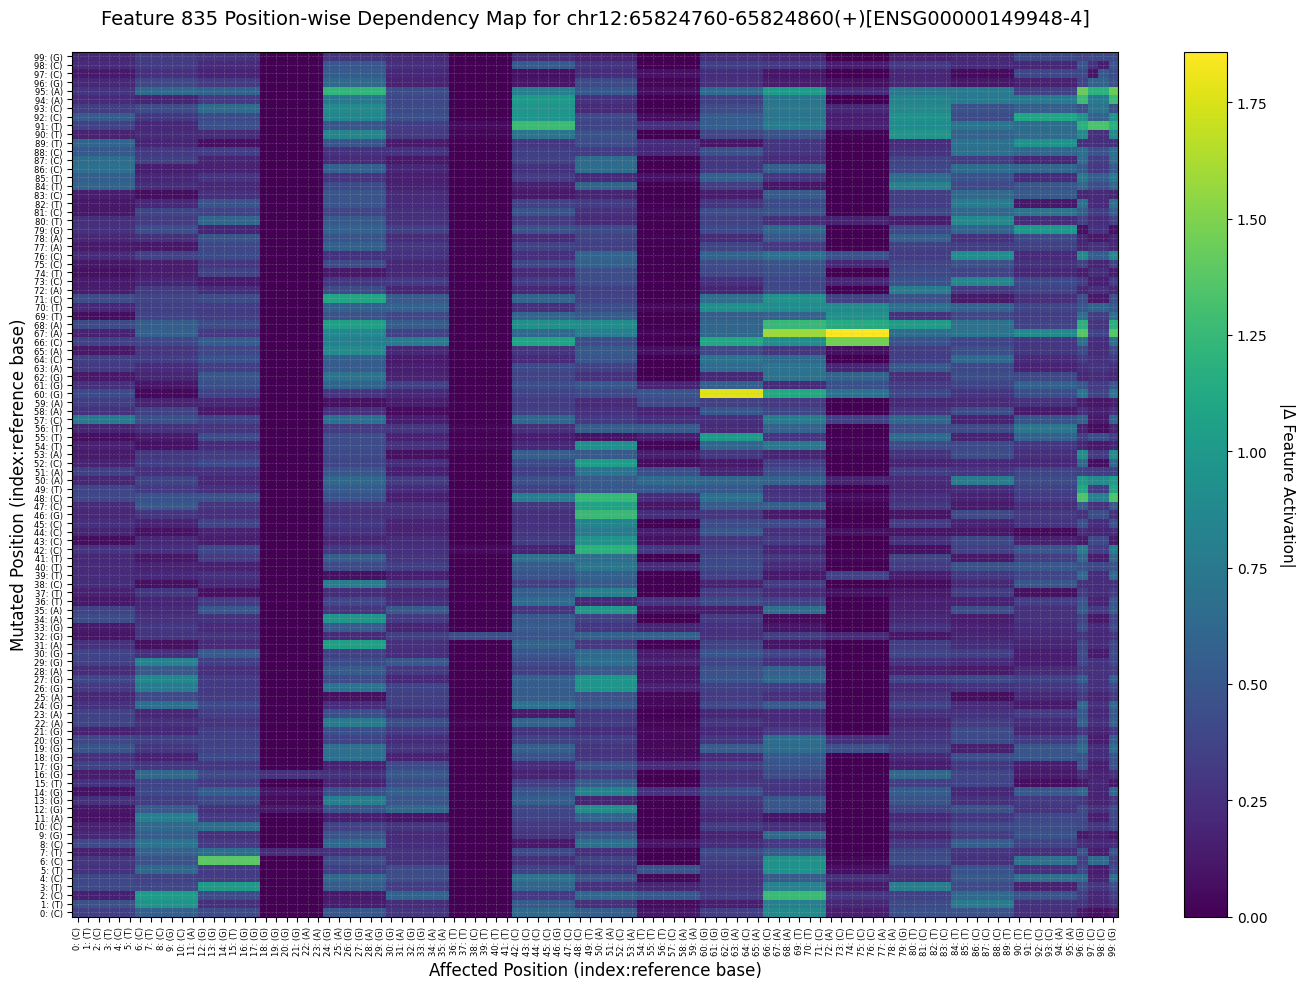


Processing Feature 5234
Calculating base-level position dependency map for feature 5234...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_5234_dependency_map.png
Max dependency delta: 2.0911
Mean dependency delta: 0.1859


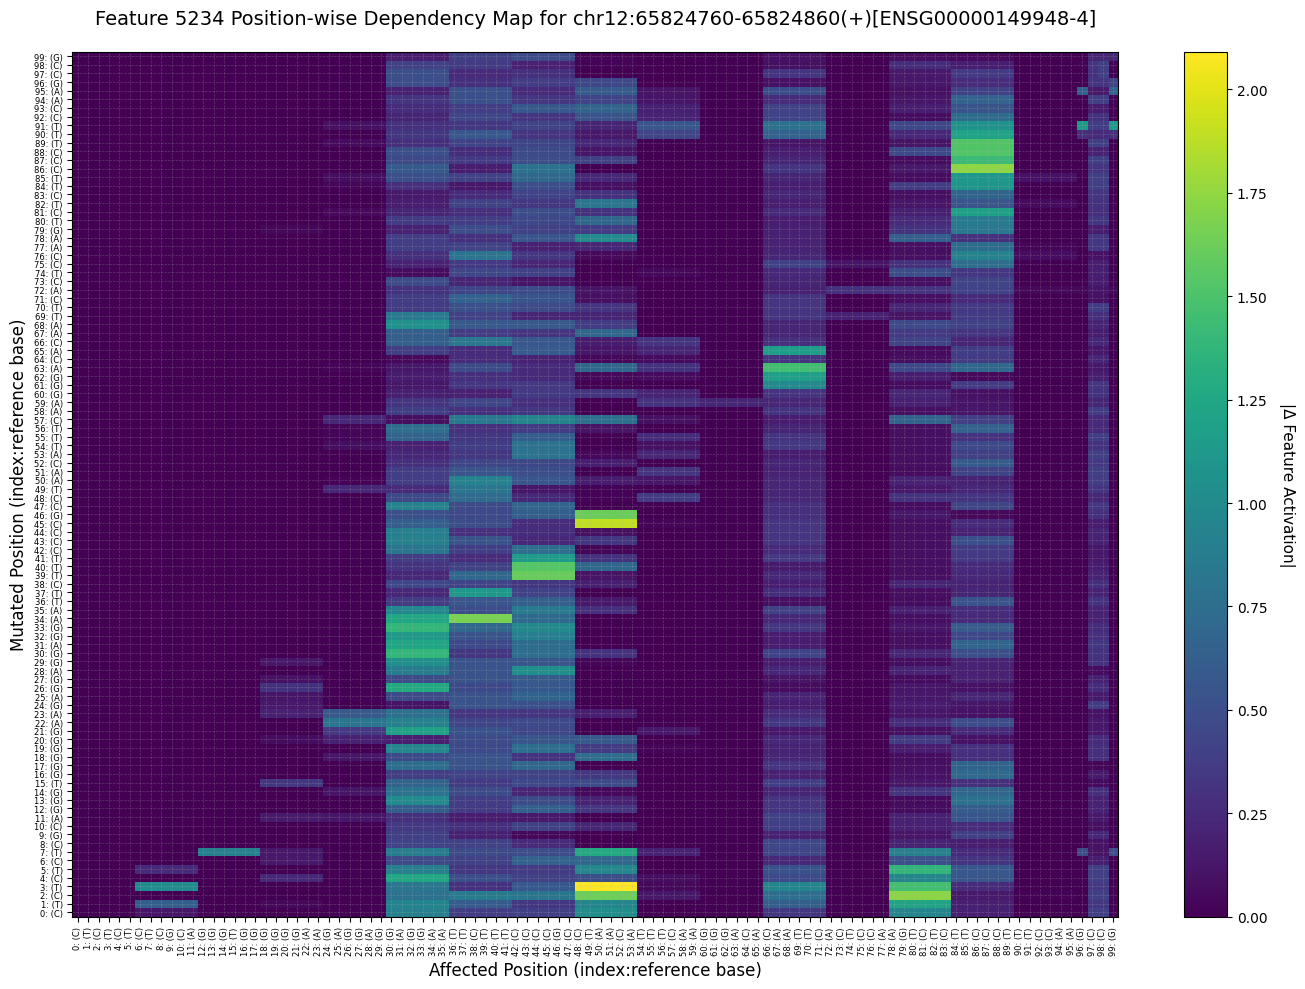


Processing Feature 3378
Calculating base-level position dependency map for feature 3378...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_3378_dependency_map.png
Max dependency delta: 3.8601
Mean dependency delta: 0.6091


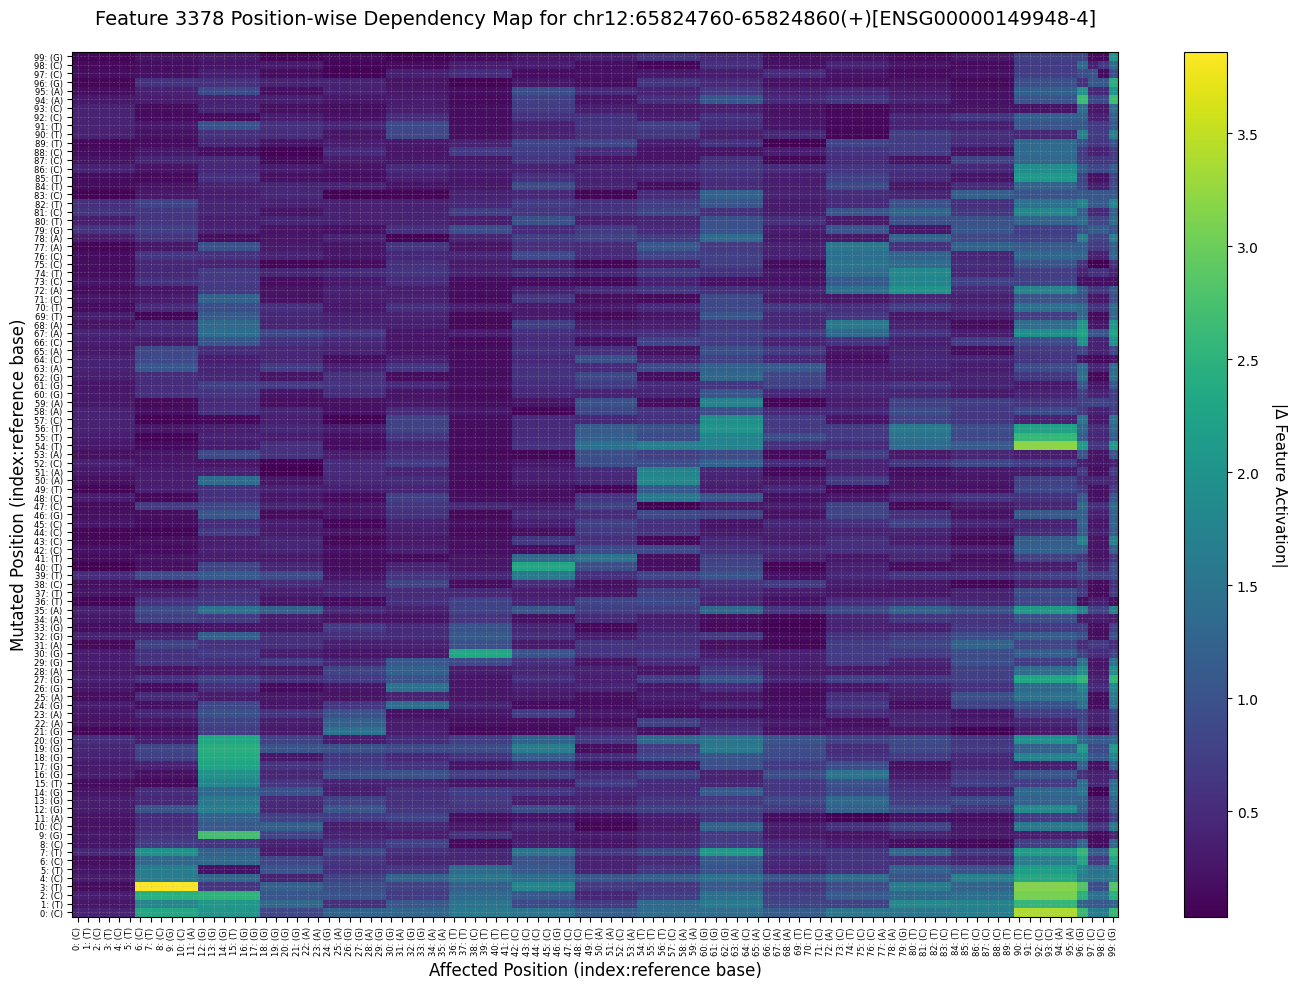


Processing Feature 7612
Calculating base-level position dependency map for feature 7612...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_7612_dependency_map.png
Max dependency delta: 3.1878
Mean dependency delta: 0.3493


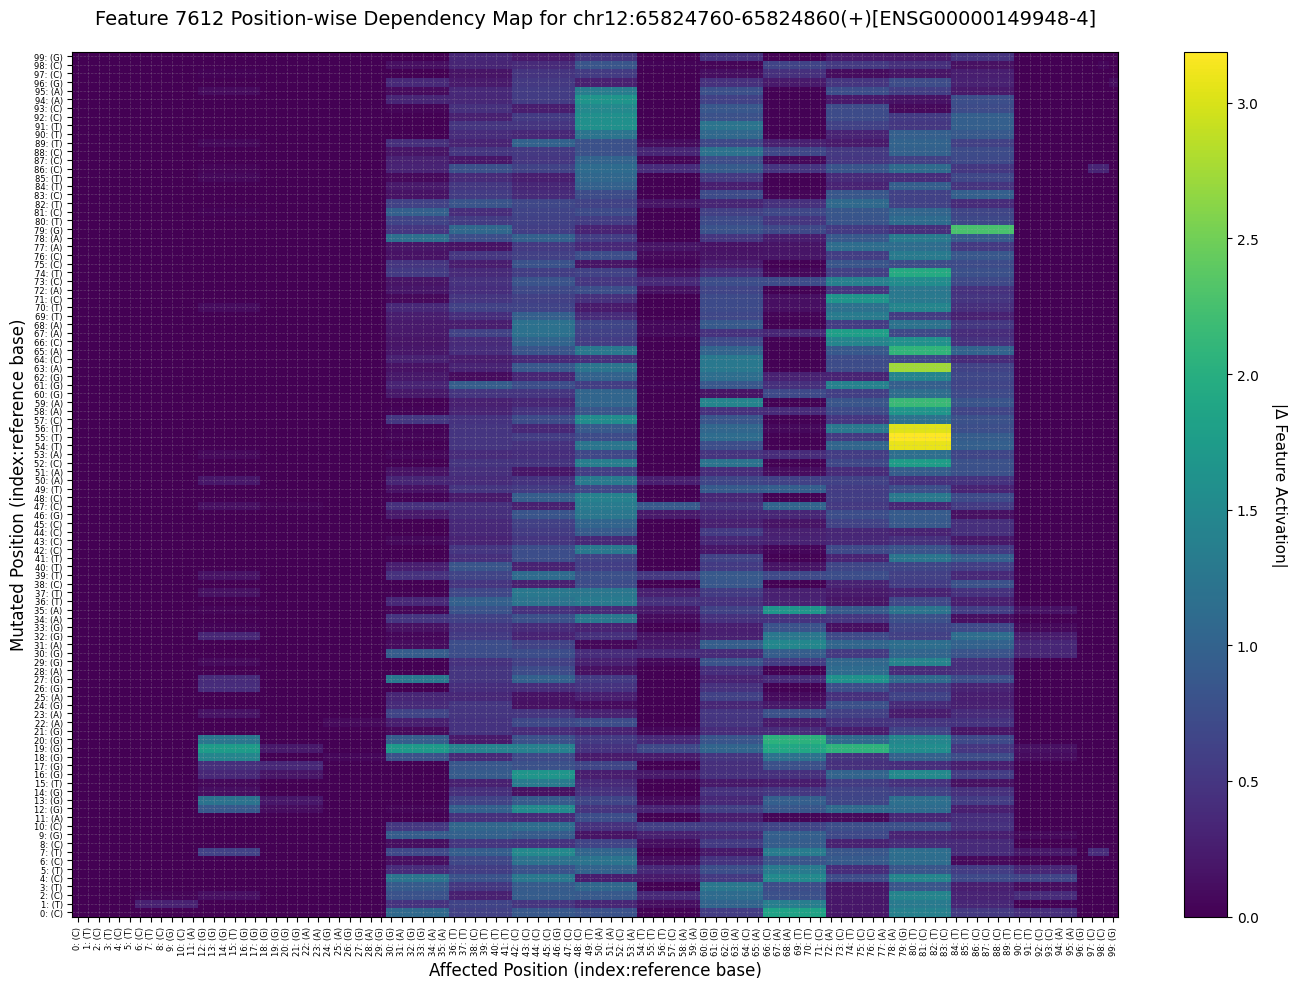


Processing Feature 7799
Calculating base-level position dependency map for feature 7799...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_7799_dependency_map.png
Max dependency delta: 1.6575
Mean dependency delta: 0.2455


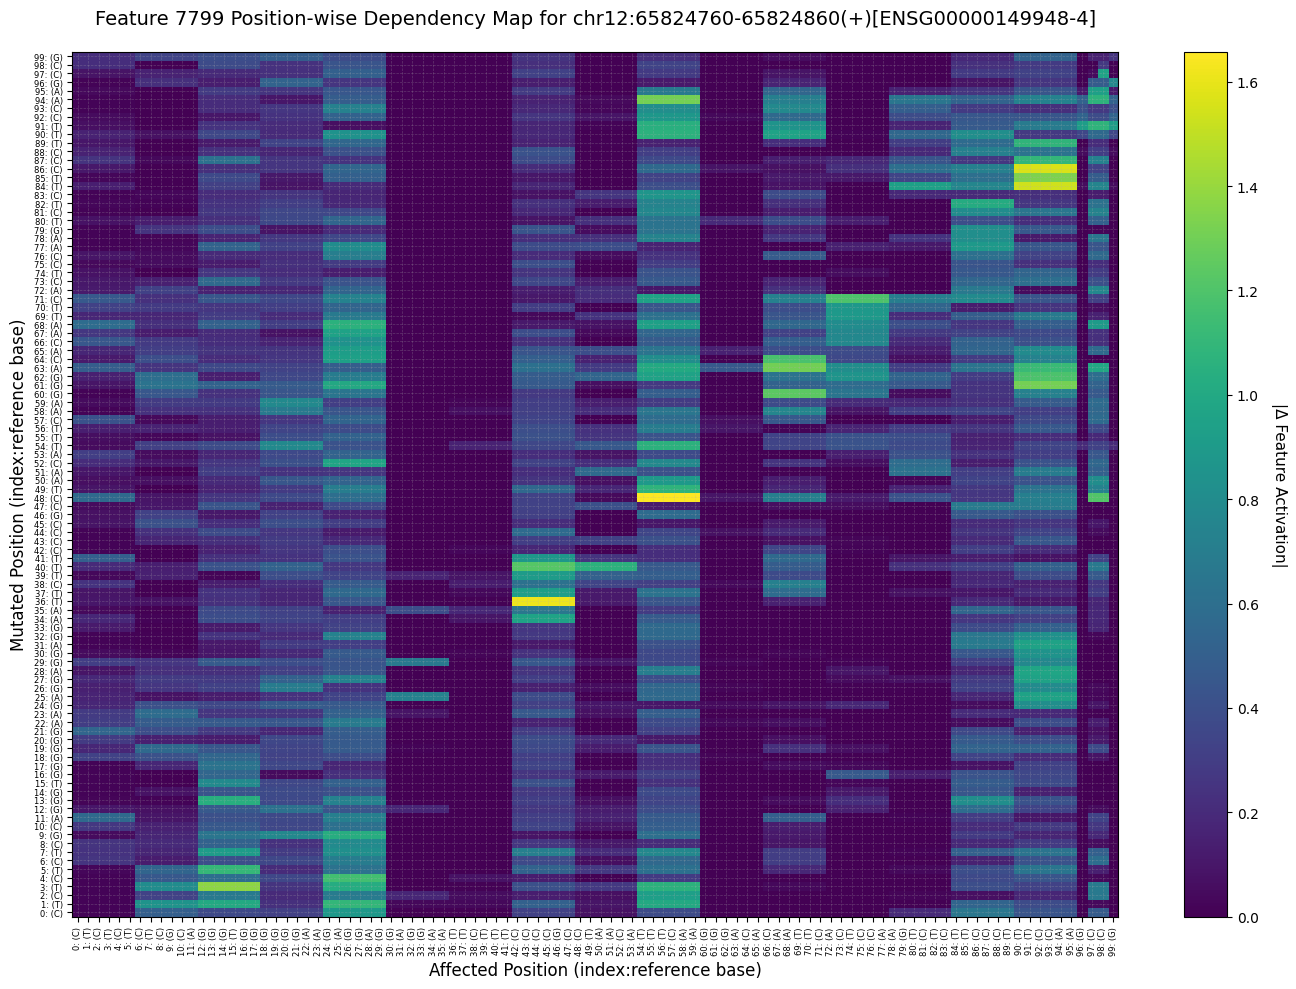


Processing Feature 7949
Calculating base-level position dependency map for feature 7949...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_7949_dependency_map.png
Max dependency delta: 1.9475
Mean dependency delta: 0.3758


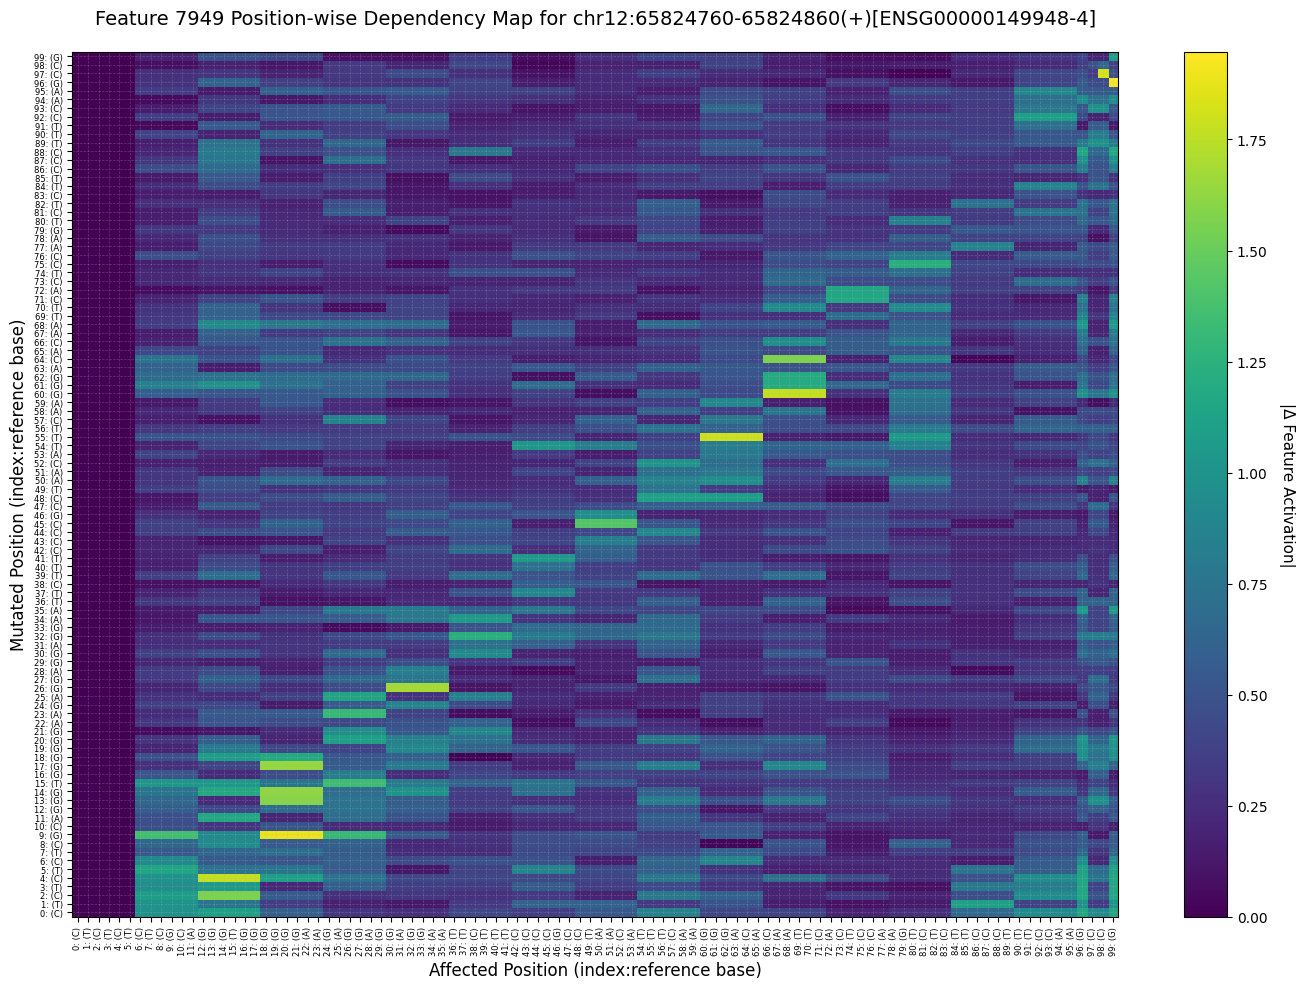


Processing Feature 1867
Calculating base-level position dependency map for feature 1867...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/dependency_maps/feature_1867_dependency_map.png
Max dependency delta: 2.3891
Mean dependency delta: 0.3380


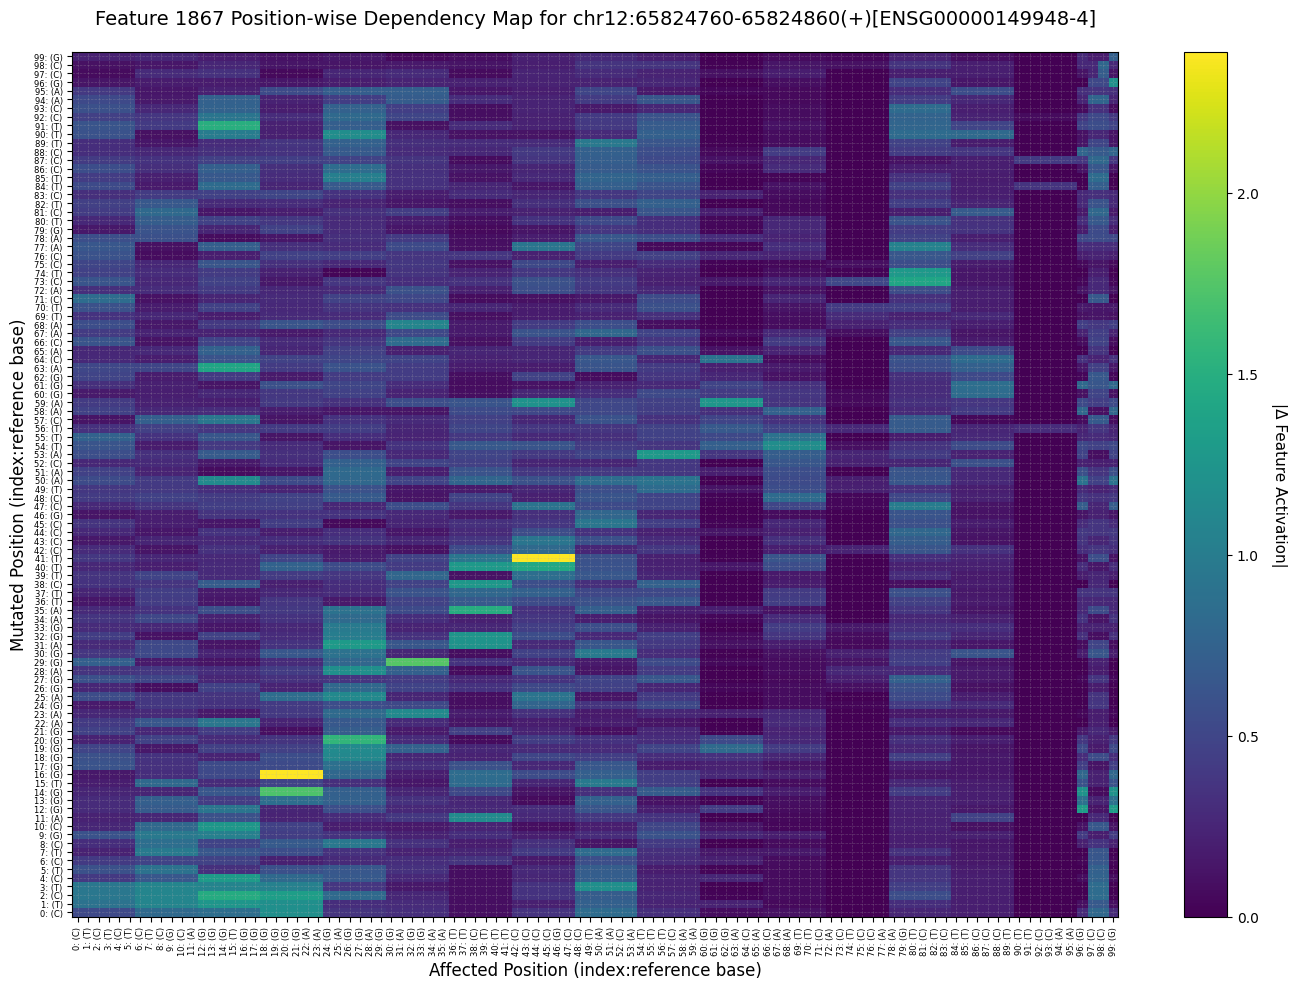


Completed 12 feature dependency maps


In [8]:
def generate_feature_dependency_heatmaps(model, sequence, feature_ids, output_dir='data/dependency_maps', show_plots=True,
                                         seq_label=None):
    """
    Generate position-wise dependency heatmaps for multiple features.
    
    Args:
        model: The LatentModel (ntsae23) with loaded SAE
        sequence: DNA sequence string to analyze
        feature_ids: Array/list of feature IDs to generate heatmaps for
        output_dir: Directory to save the heatmap images
        show_plots: Whether to display plots (default: True)
        
    Returns:
        dict: Dictionary mapping feature_id to results dict
    """
    all_results = {}
    
    for feature_id in feature_ids:
        print(f"\n{'='*60}")
        print(f"Processing Feature {feature_id}")
        print(f"{'='*60}")
        
        # Generate appropriate title
        if seq_label:
            title = f'Feature {feature_id} Position-wise Dependency Map for {seq_label}'
        else:
            title = None
        
        # Generate save path
        os.makedirs(output_dir, exist_ok=True)
        save_path = f'{output_dir}/feature_{feature_id}_dependency_map.png'
        
        # Analyze and plot
        results = analyze_sequence_dependency(
            model=model,
            sequence=sequence,
            feature_id=feature_id,
            plot=True,
            save_path=save_path,
            title=title
        )
        
        all_results[feature_id] = results
        
        if show_plots:
            plt.show()
        else:
            plt.close()
    
    print(f"\n{'='*60}")
    print(f"Completed {len(feature_ids)} feature dependency maps")
    print(f"{'='*60}")
    
    return all_results


# Generate heatmaps for all multiedge core positive features
test_sequence = cisplat_binding_sites["sequences"][0]
test_seq_id = ''.join([
    f"{cisplat_binding_sites["chrom"][0]}:",
    f"{cisplat_binding_sites["chromStart"][0]}-",
    f"{cisplat_binding_sites["chromEnd"][0]}",
    f"({cisplat_binding_sites["strand"][0]})",
    f"[{cisplat_binding_sites["name"][0]}]"
])

feature_results = generate_feature_dependency_heatmaps(
    model=ntsae23,
    sequence=test_sequence,
    feature_ids=multiedge_core_pos_feats,
    output_dir='data/dependency_maps',
    show_plots=True,
    seq_label=test_seq_id
)


Processing Feature 7030
Calculating base-level position dependency map for feature 7030...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Generating heat map...
Plot saved to: data/intervention_reports/feature_7030_dependency_map.png
Max dependency delta: 3.2364
Mean dependency delta: 0.3869


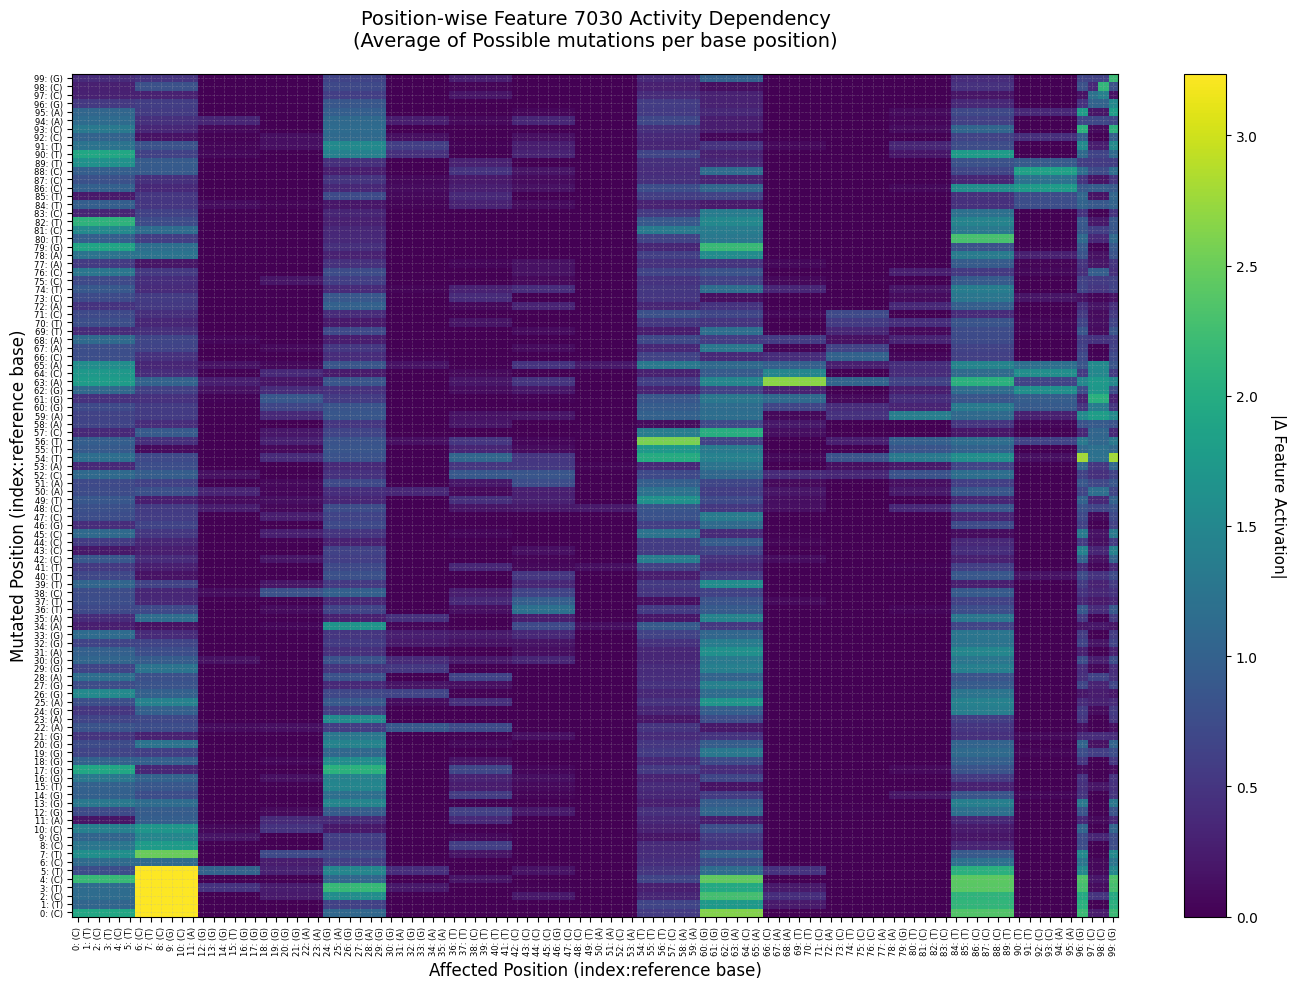


Processing Feature 8161
Calculating base-level position dependency map for feature 8161...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/intervention_reports/feature_8161_dependency_map.png
Max dependency delta: 3.3218
Mean dependency delta: 0.2602


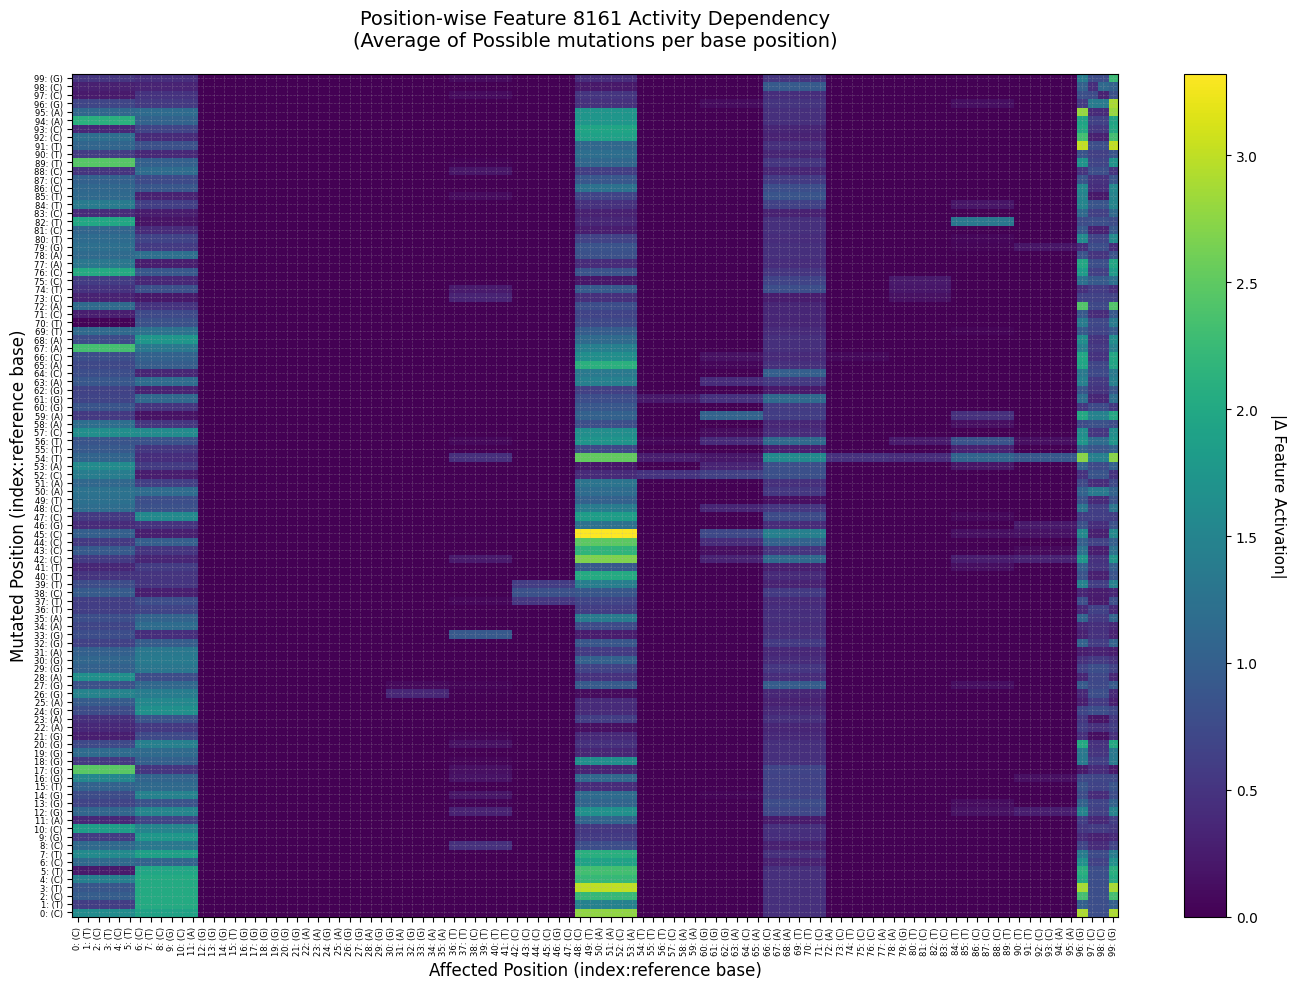


Processing Feature 1422
Calculating base-level position dependency map for feature 1422...
Sequence length: 100 bp
Computing dependency map for 100 positions...


Mutating positions: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Generating heat map...
Plot saved to: data/intervention_reports/feature_1422_dependency_map.png
Max dependency delta: 1.9713
Mean dependency delta: 0.1068


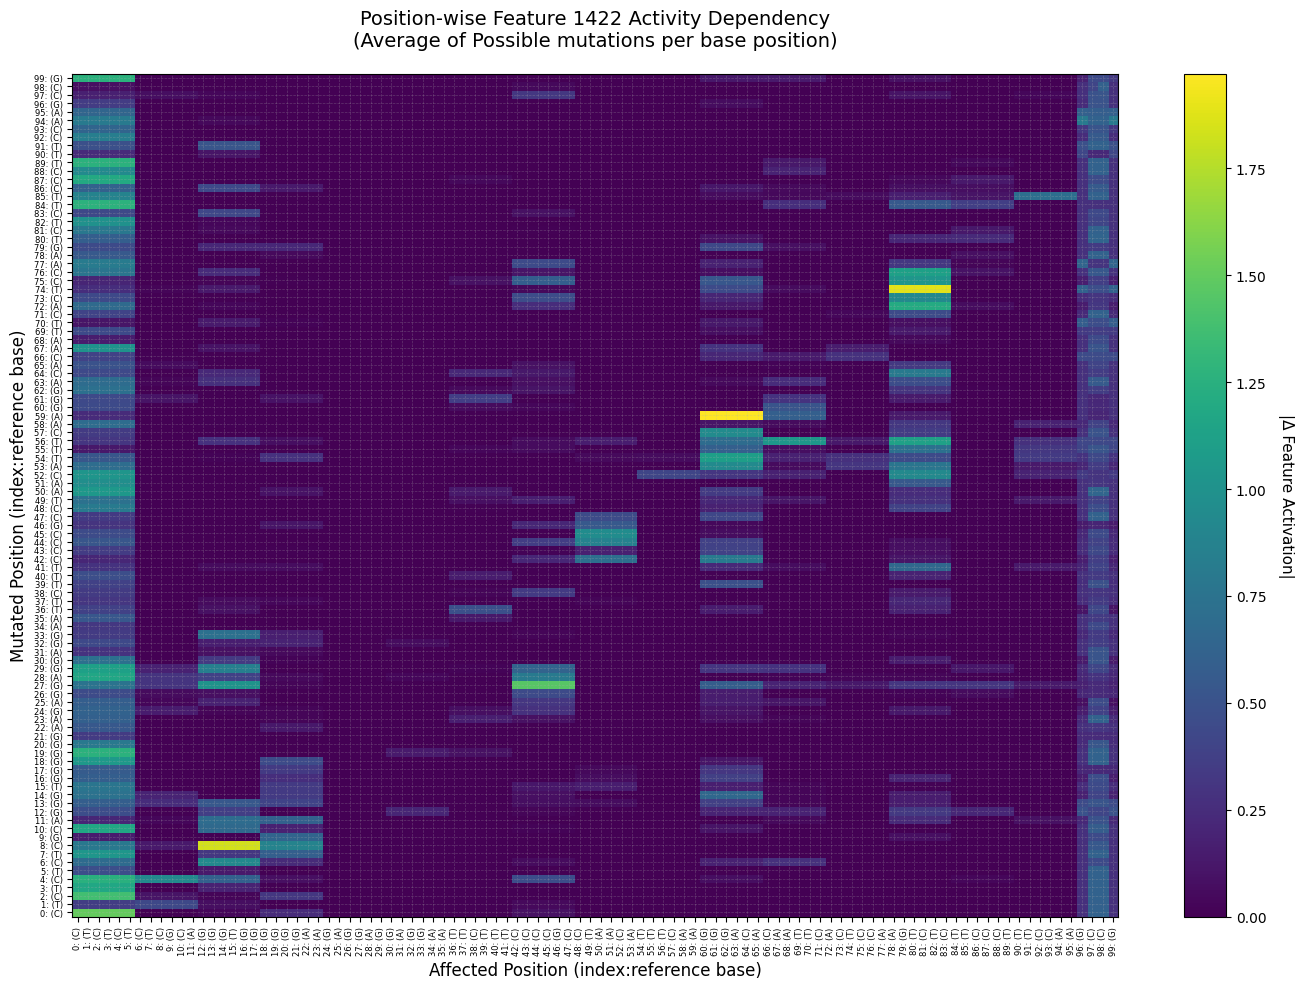


Completed 3 feature dependency maps


In [9]:
neg_feature_results = generate_feature_dependency_heatmaps(
    model=ntsae23,
    sequence=test_sequence,
    feature_ids=steered_feat,
    output_dir='data/intervention_reports',
    show_plots=True
)